# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [2]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [3]:
# ratings = pd.read_csv('/content/drive/MyDrive/music_dataset.csv')
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [4]:
# tracks_info = pd.read_csv('/content/drive/MyDrive/tracks_info.csv')
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [98]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    mapk = []

    for user_idx, user in enumerate(predicted[:len(relevant)]):
        apk = []

        for i, track in enumerate(user[:k]):
            
            if track in relevant[user_idx]:
                apk.append(sum([
                          1 for elem in user[:i+1]
                          if elem in relevant[user_idx]
                          ]) / (i+1))

        mapk.append(sum(apk) / min(k, len(relevant[user_idx])))

    return sum(mapk) / len(mapk)

In [6]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [7]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [8]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [9]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [10]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [11]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [12]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [13]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [14]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

In [15]:
len(test_relevant), len(test_users)

(235, 235)

**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [97]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings_df = ratings
        self.n_users = len(np.unique(self.ratings_df['userId']))
        self.n_items = len(np.unique(self.ratings_df['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings_df['userId'], self.ratings_df['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings_df.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds.astype(int)

    def get_test_recommendations(self, k: int):
        test_preds = []

        for uid, user_data in enumerate(self.ratings):
            raw_preds = self.recommend(uid)
            test_preds.append(raw_preds)
            
        clean_preds = self.remove_train_items(test_preds, k)

        return clean_preds

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [17]:
from numpy.linalg import norm

In [54]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    
    l2norm_r_ui = norm(ratings, 2, axis=1)
    l2norm_r_vi = norm(user_vector, 2)
    
    return ratings @ user_vector / (l2norm_r_ui * l2norm_r_vi)


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    
    intersect = ratings * user_vector
    
    sum_rat_user = ratings + user_vector
    union = np.where(sum_rat_user == 2,
                     np.ones(sum_rat_user.shape[1]),
                    sum_rat_user)
    
    return intersect.sum(axis=1) / union.sum(axis=1)

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [55]:
def make_ohe_vector(tracks, num_tracks):
    ohe_ratings = np.zeros(num_tracks, dtype=int)
    np.put(ohe_ratings, tracks, 1)
    
    return pd.Series(ohe_ratings)

In [99]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings) 
        
        # превращаем датафрейм в матрицу оценок
        lists_of_tracks = ratings.groupby('userId')['trackId'].apply(lambda a: a.values)
        self.ratings = lists_of_tracks.apply(
            lambda tracks: make_ohe_vector(tracks, self.n_items)
        ).to_numpy()

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array, ratings: np.array):
        """
        user_vector: [n_items]
        ratings: [n_users, n_items]
        """
        return self.similarity_func(ratings, user_vector)

    def recommend(self, uid: int):
        user_vector = self.ratings[uid]
        v_ratings = np.delete(self.ratings, uid, axis=0)
        
        simil = self.similarity(user_vector, v_ratings)
        mask_simil = simil * (simil > self.alpha)
        
        r_ui = sum(
            np.apply_along_axis(lambda x: x * mask_simil, 0, v_ratings) 
        ) / sum(np.abs(simil))

        return np.argsort(r_ui)[::-1]

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [101]:
ks = [5, 10, 15, 20, 25, 30] # исходил из количества песен у каждого юзера в тесте, 
                            # однако при бОльших значениях k качество не меняется

In [103]:
# по Пирсону
mapks_pearson = []
user2user_pearson = User2User(train_ratings, pearson)
for k in ks:
    predict = user2user_pearson.get_test_recommendations(k)
    mapks_pearson.append(mapk(test_relevant, predict, k))

In [107]:
mapks_pearson

[0.0014184397163120566,
 0.0013253968253968253,
 0.0009766726575237213,
 0.0008168286483367835,
 0.0007356785999970416,
 0.0007072788778988558]

In [106]:
# по Жаккару
mapks_jaccard = []
user2user_jaccard = User2User(train_ratings, jaccard)
for k in ks:
    predict_jaccard = user2user_jaccard.get_test_recommendations(k)
    mapks_jaccard.append(mapk(test_relevant, predict_jaccard, k))

In [108]:
mapks_jaccard

[0.0013475177304964538,
 0.0010624788922661264,
 0.0008024520790478236,
 0.0007155228306667608,
 0.0007856484564129991,
 0.0007558564125769259]

In [117]:
# случайное предсказание
mapks_random = []
for k in ks:
    predict_random = np.random.randint(0, 
                                       high=ratings['trackId'].nunique(), 
                                       size=(ratings['userId'].nunique(), k))
    mapks_random.append(mapk(test_relevant, predict_random, k))

In [118]:
mapks_random

[0.00021276595744680854,
 0.0,
 0.00014184397163120567,
 2.4496080627099666e-05,
 0.00021694710981319242,
 0.0]

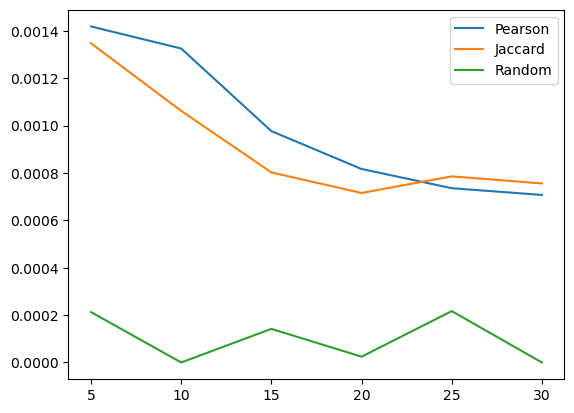

In [121]:
plt.plot(ks, mapks_pearson, label='Pearson')
plt.plot(ks, mapks_jaccard, label='Jaccard')
plt.plot(ks, mapks_random, label='Random')
plt.legend()
plt.show()

ну получше, чем рандом, но чето мега плохо) возможно, близкие юзеры оказались совсем не близкими или со слишком разнообразными предпочтениями

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [ ]:
# your code here: ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [123]:
user_id = np.random.randint(0, user2user_pearson.n_users)

In [124]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
164,My Favourite Game,['The Cardigans']
2194,I'm A Man,['Black Strobe']
3123,Erotica,['Madonna']
3467,Love Don't Let Me Go,['David Guetta']
6125,I Just Want You,['Ozzy Osbourne']
7973,Left Outside Alone,['Anastacia']
9818,Папиросы,['Зануда']
9819,Монпасье,['Зануда']
9821,Всё пиздато,['Зануда']
10282,Владивосток 2000,['Мумий Тролль']


In [125]:
preds = user2user_pearson.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
805,Zombie,['The Cranberries']
1019,It's My Life,['Bon Jovi']
1073,Smells Like Teen Spirit,['Nirvana']
2814,Numb,['Linkin Park']
8263,Shape Of My Heart,['Sting']
2481,Gangsta's Paradise,"['Coolio', 'L.V.']"
11493,The Show Must Go On,['Queen']
9694,We Will Rock You,['Queen']
7533,Highway to Hell,['AC/DC']
40209,Выхода нет,['Сплин']


ну вот тут мы видим некоторые совпадения в жанровых предпочтениях: у юзера в прослушанных было немного рока или чего-то альтернативного, и мы ему порекомендовали много рока

In [126]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
61759,Весна,['Русский Размер']
62752,Забывай,['МакSим']
62857,Тлеет,"['SVNV', 'BULA']"
63218,Бамбина,['ГУДЗОН']
63825,Снежинка,['Анастасия Сотникова']
63944,Ты не один,['Ольга Play']
63988,If You Love Me,"['Мари Краймбрери', 'Alex Davia']"
64005,Горький вкус,['Султан Лагучев']
64196,Дайте мужика,['VESNA305']
64301,Спасибо,['МакSим']


реальные треки юзера не очень похожи на то, что мы предсказывали, и достаточно специфичны

### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**LFM:**

Ответ $$
q_{i} = q_{i} + \eta    ((r_{ui} - \hat{r}_{ui}) p_{u} - \lambda  q_{i})
$$

$$
p_{u} = p_{u} + \eta    ((r_{ui} - \hat{r}_{ui}) q_{i} - \lambda  p_{u})
$$

\\
**ALS:**

Ответ
$$
p_{u} = (Q^TC^uQ + \lambda I)^{-1}Q^TC^up(u)
$$

$$
q_{i} = (P^TC^iP + \lambda I)^{-1}P^TC^ip(i)
$$

**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [ ]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                pass

            elif self.mode == 'als':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                pass

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [ ]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
5517,Варвара,['Би-2'],0.649796
17328,Я хочу быть с тобой,['Nautilus Pompilius'],0.646846
2058,Последний герой,['КИНО'],0.640997
5872,Я свободен,['Кипелов'],0.606749
2060,Хочу перемен,['КИНО'],0.603231
5515,Романс,['Сплин'],0.590318
24284,Как на войне,['Агата Кристи'],0.586219
4463,Holiday,['Green Day'],0.576644
2179,Восьмиклассница,['КИНО'],0.570639
